#### imports

In [2]:
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
import optuna
from xgboost import XGBRanker
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("../../intern_task.csv")

In [4]:
df.head(5)

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,0.0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667
2,0,10,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,...,0.0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333
3,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667
4,2,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,273.0,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000


In [5]:
# Checking the ranks and queries
display(df["rank"].value_counts())
display(df["query_id"].value_counts())

rank
0    121521
1     75815
2     31910
3      4209
4      1803
Name: count, dtype: int64

query_id
22540    908
13930    773
22450    522
19945    444
9940     430
        ... 
22780      2
14350      2
9265       1
20560      1
28285      1
Name: count, Length: 2000, dtype: int64

In [6]:
# Checking for empty cells
df.isna().sum().sum()

0

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


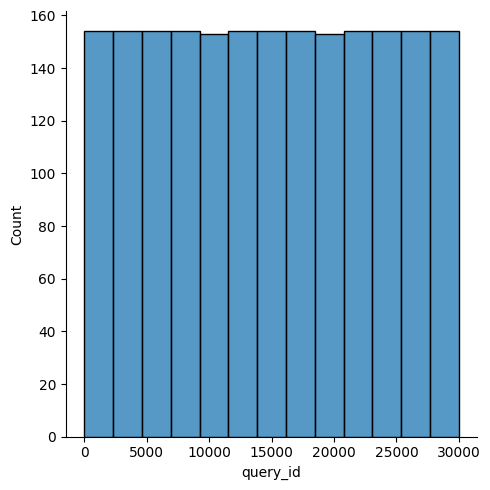

In [7]:
# Checking the distribution of queries (not informative)
sns.displot(pd.DataFrame(df["query_id"].value_counts()), x = "query_id")

In [8]:
# Checking features, that has a linear dependence
corr_matrix = df.corr().abs()
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))

edges = []

for index, value in sol.items():
    if value >= 0.9:
        print(index, value)

('feature_8', 'feature_35') 1.0000000000000004
('feature_8', 'feature_20') 0.9999999999999944
('feature_20', 'feature_35') 0.9999999999999729
('feature_15', 'feature_19') 0.9998923068772728
('feature_70', 'feature_74') 0.9995993654456882
('feature_90', 'feature_94') 0.9993228493483797
('query_id', 'feature_20') 0.999008865085595
('query_id', 'feature_35') 0.9990088650854946
('query_id', 'feature_8') 0.9990088650853508
('feature_24', 'feature_142') 0.9990069140447361
('feature_113', 'feature_123') 0.9979516883031102
('feature_111', 'feature_121') 0.9977340997300704
('feature_115', 'feature_119') 0.9975819022050179
('feature_40', 'feature_44') 0.997457578524885
('feature_30', 'feature_34') 0.9973567492206938
('feature_80', 'feature_84') 0.9970876324330716
('feature_10', 'feature_14') 0.9970138582466481
('feature_39', 'feature_143') 0.9968184714179738
('feature_85', 'feature_89') 0.996235182004619
('feature_114', 'feature_124') 0.996158117531289
('feature_25', 'feature_29') 0.996002122792

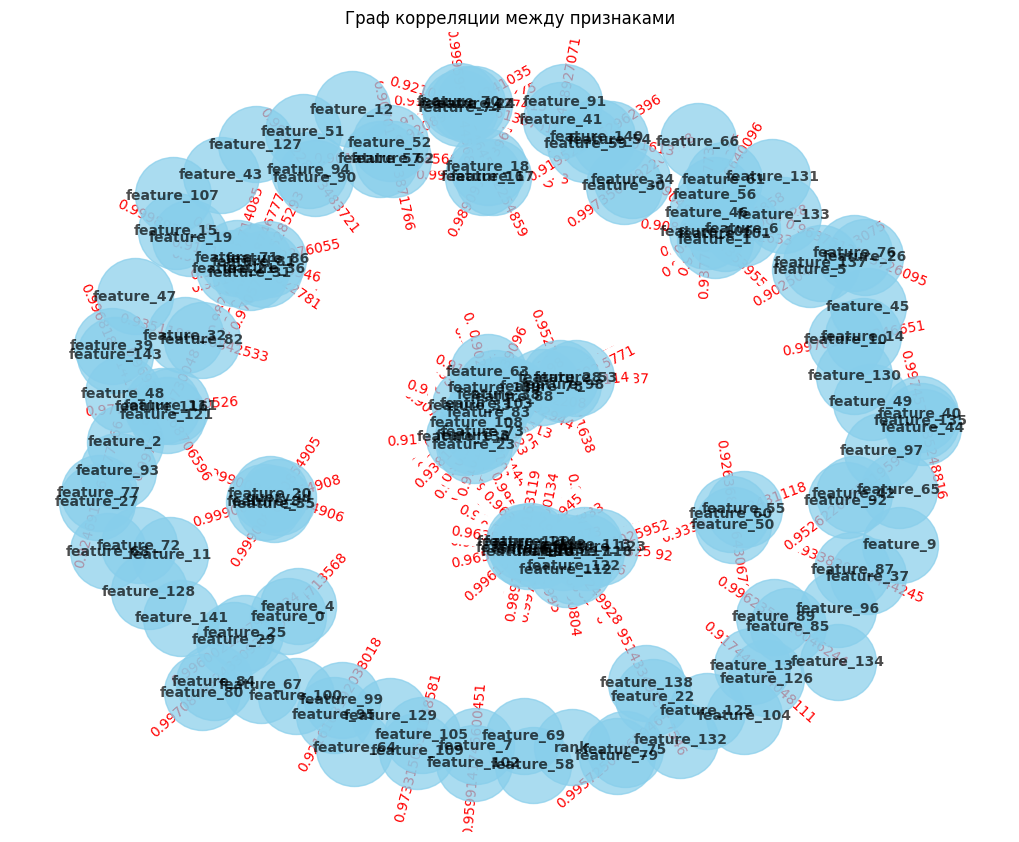

In [9]:
# Finding connected components in the graph, constructed from features as nodes and the fact features correlates big enough as edges
# Then I am deleting all nodes in components except one (put simply, compressing component into one node)

G = nx.Graph()

G.add_nodes_from(df.columns)

for i in range(len(df.columns)):
    for j in range(i+1, len(df.columns)):
        corr_coef = df[df.columns[i]].corr(df[df.columns[j]])
        if abs(corr_coef) >= 0.9:
            G.add_edge(df.columns[i], df.columns[j], weight = corr_coef)

plt.figure(figsize = (10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels = True, node_size = 3000, node_color = "skyblue", font_size = 10, font_weight = "bold", edge_color = "gray", width = 3, alpha = 0.7)
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_color = "red")
plt.title("Граф корреляции между признаками")
plt.show()

for component in nx.connected_components(G):
    if len(component) > 1:
        central_node = list(component)[0]
        if "query_id" in list(component):
            if "rank" in list(component):
                continue
            else:
                central_node = "query_id"
        if "rank" in list(component):
            central_node = "rank"
        nodes_to_remove = list(component - {central_node})
        df.drop(columns = nodes_to_remove, inplace = True)

In [10]:
df.head(5)

,rank,query_id,feature_1,feature_2,feature_4,feature_5,feature_9,feature_10,feature_11,feature_12,...,feature_128,feature_129,feature_130,feature_131,feature_132,feature_133,feature_134,feature_135,feature_138,feature_141
0,0,10,0.0,1.0,3.0,0.333333,1.0,10.0,0.0,9.0,...,0.0,153.0,3866.0,17.0,104.0,0.0,0.0,0.000000,8.655534,0.002222
1,1,10,0.0,3.0,3.0,1.000000,1.0,557.0,0.0,7.0,...,9.0,266.0,56137.0,5.0,2.0,0.0,0.0,0.000000,23.130514,0.000430
2,0,10,0.0,2.0,3.0,1.000000,1.0,522.0,0.0,6.0,...,0.0,541.0,12621.0,11.0,11.0,0.0,0.0,0.000000,13.351339,0.000104
3,1,10,0.0,3.0,3.0,1.000000,1.0,59.0,0.0,5.0,...,0.0,14687.0,40205.0,5.0,3.0,0.0,0.0,0.000000,18.240926,0.000255
4,2,10,0.0,3.0,3.0,1.000000,1.0,203.0,0.0,7.0,...,1.0,10577.0,34605.0,1.0,1.0,2175.0,273.0,79.670665,31.786048,0.000307


In [11]:
df.sort_values(by = "query_id", inplace = True)

In [12]:
def train_test_split(df, test_size = 0.2, random_state=None):
    if random_state:
        np.random.seed(random_state)
    unique_queries = df['query_id'].unique()
    test_queries = np.random.choice(unique_queries, size = int(test_size*len(unique_queries)), replace = False)
    test_mask = df['query_id'].isin(test_queries)
    train_df = df[~test_mask]
    test_df = df[test_mask]
    return train_df, test_df

In [45]:
train_df, test_df = train_test_split(df)
imp_feats = [feature for feature in df.columns if feature.startswith("feature")]

from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

# Trying to find the best parametres
def instantiate_model(trial):
    params = {
        "objective" : "rank:ndcg",
        "booster" : "gbtree",
        "random_state" : 42,
        "learning_rate" : trial.suggest_float("learning_rate", 0.05, 0.15, log = True),
        "n_estimators" : 250,
        "max_depth" : 5,
        "subsample" : trial.suggest_float("subsample", 0.5, 0.8),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.85, 1.0)
    }
    return xgb.XGBRanker(**params)

def objective(trial):
    kf = KFold(n_splits = 3, shuffle = True, random_state = 42)
    scores = []
    for train_idx, val_idx in kf.split(train_df):
        train_data = train_df.iloc[train_idx]
        val_data = train_df.iloc[val_idx]

        model = instantiate_model(trial = trial)
        model.fit(
            X = train_data.drop(["query_id", "rank"], axis = 1),
            y = train_data["rank"],
            group = train_data.groupby("query_id").size().values,
            eval_set = [(
                val_data.drop(["query_id", "rank"], axis=1),
                val_data["rank"]
            )],
            eval_group = [val_data.groupby("query_id").size().values],
            eval_metric = ["ndcg@10"],
            early_stopping_rounds = 10,
            verbose = False
        )
        score = model.best_score
        scores.append(score)

    return np.mean(scores)

study = optuna.create_study(study_name = "XGBRanker", direction = "maximize")
study.optimize(objective, n_trials = 25)
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-04-29 18:13:09,208] A new study created in memory with name: XGBRanker
[I 2024-04-29 18:13:47,889] Trial 0 finished with value: 0.5736347330422621 and parameters: {'learning_rate': 0.07414322975422497, 'subsample': 0.7805945848376334, 'colsample_bytree': 0.8961942816474409}. Best is trial 0 with value: 0.5736347330422621.
[I 2024-04-29 18:14:19,270] Trial 1 finished with value: 0.5674656818330114 and parameters: {'learning_rate': 0.06010389890127217, 'subsample': 0.7406872486649564, 'colsample_bytree': 0.9933959137813229}. Best is trial 0 with value: 0.5736347330422621.
[I 2024-04-29 18:14:53,676] Trial 2 finished with value: 0.5699400949825494 and parameters: {'learning_rate': 0.055918533385245744, 'subsample': 0.5610986419146204, 'colsample_bytree': 0.9697516744939767}. Best is trial 0 with value: 0.5736347330422621.
[I 2024-04-29 18:15:13,456] Trial 3 finished with value: 0.5708071215506029 and parameters: {'learning_rate': 0.13692852172469486, 'subsample': 0.714300809583978

  Value: 0.5772304800037316
  Params: 
    learning_rate: 0.11345725277194903
    subsample: 0.7637670796842478
    colsample_bytree: 0.9668027287176424


In [46]:
best_model = instantiate_model(trial = trial)
best_model.fit(
    X=train_df.drop(['query_id', 'rank'], axis=1),
    y=train_df['rank'],
    group=train_df.groupby('query_id').size().values,
    eval_set=[(
        train_df.drop(['query_id', 'rank'], axis=1),
        train_df['rank']
    )],
    eval_group=[train_df.groupby('query_id').size().values],
    eval_metric=['ndcg@10'],
    early_stopping_rounds = 10,
    verbose = True
)

[0]	validation_0-ndcg@10:0.41091
[1]	validation_0-ndcg@10:0.43995
[2]	validation_0-ndcg@10:0.44400
[3]	validation_0-ndcg@10:0.45082
[4]	validation_0-ndcg@10:0.45544
[5]	validation_0-ndcg@10:0.45765
[6]	validation_0-ndcg@10:0.46178
[7]	validation_0-ndcg@10:0.46370
[8]	validation_0-ndcg@10:0.46580
[9]	validation_0-ndcg@10:0.46927
[10]	validation_0-ndcg@10:0.47141
[11]	validation_0-ndcg@10:0.47441
[12]	validation_0-ndcg@10:0.47569
[13]	validation_0-ndcg@10:0.47712
[14]	validation_0-ndcg@10:0.47793
[15]	validation_0-ndcg@10:0.47953
[16]	validation_0-ndcg@10:0.48082
[17]	validation_0-ndcg@10:0.48240
[18]	validation_0-ndcg@10:0.48386
[19]	validation_0-ndcg@10:0.48470
[20]	validation_0-ndcg@10:0.48514
[21]	validation_0-ndcg@10:0.48710
[22]	validation_0-ndcg@10:0.48772
[23]	validation_0-ndcg@10:0.48939
[24]	validation_0-ndcg@10:0.49072
[25]	validation_0-ndcg@10:0.49122
[26]	validation_0-ndcg@10:0.49308
[27]	validation_0-ndcg@10:0.49539
[28]	validation_0-ndcg@10:0.49706
[29]	validation_0-ndcg@1

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None,
          colsample_bytree=0.9668027287176424, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None,
          learning_rate=0.11345725277194903, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=250,
          n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [52]:
from sklearn.metrics import ndcg_score

y_pred = best_model.predict(test_df.drop(['query_id', 'rank'], axis=1))

def expected_reciprocal_rank(y_score):
    result = 0.0
    prob_step_down = 1.0
    
    for rank, rel in enumerate(y_score):
        rank += 1
        utility = pow(2, rel) / pow(2, max(y_score))
        result += prob_step_down * utility / rank
        prob_step_down *= (1 - utility) 
      
    return result

ndcg_5_scores = []
err_scores = []
for query_id in test_df['query_id'].unique():
    query_mask = test_df['query_id'] == query_id
    y_true_query = test_df[query_mask]['rank'].values
    y_pred_query = y_pred[query_mask]
    if len(y_true_query) >= 5:
        ndcg_5_scores.append(ndcg_score([y_true_query], [y_pred_query], k = 5))
        err_scores.append(expected_reciprocal_rank(y_pred_query))

print(f"NDCG@5 : {np.mean(ndcg_5_scores)}")
print(f"ERR : {np.mean(err_scores)}")

NDCG@5 : 0.542936685464951
ERR : 0.46802011390689074
